# Introduction to NLP Fundamentals in TensorFlow

## Check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-758ed2ea-b78a-2deb-7f92-44d8ca219f17)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-12 19:08:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-12 19:08:25 (78.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Get a text dataset
Let's start by download a text dataset. We'll be using the Real or Not? dataset from Kaggle which contains text-based Tweets about natural disasters.

In [4]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2024-02-12 19:08:33--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 74.125.20.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.008s  

2024-02-12 19:08:34 (72.0 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

In [5]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [7]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [11]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df) - 5)
for row in train_df_shuffled[["text", "target"]][random_index: random_index + 5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "not real disaster")
  print(f"Text:\n{text}\n")
  print("---\n")


Target: 0 not real disaster
Text:
What's going on in Hollywood? #abc7eyewitness @ABC7 helicopters and sirens. #HometownGlory

---

Target: 1 (real disaster)
Text:
Kids Disappear in Dust Storm in Atmospheric Aussie Thriller http://t.co/TPOaprJudp RT @Newz_Sacramento

---

Target: 0 not real disaster
Text:
@MzMandiLynn GM! I pray any attack of the enemy 2 derail ur destiny is blocked by the Lord &amp; that He floods ur life w/heavenly Blessings

---

Target: 1 (real disaster)
Text:
Two giant cranes holding a bridge collapse into nearby homes http://t.co/q5q1x5Vcqk

---

Target: 1 (real disaster)
Text:
Nine inmates charged with causing damage in Calgary Remand Centre riot - http://t.co/1OSmIUXKhW

---



### Split data into training and validation sets

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Use train_test_split to split training data intp training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # 10% for validation
                                                                            random_state=42)

In [14]:
len(train_sentences), len(train_labels)

(6851, 6851)

In [15]:
len(val_sentences), len(val_labels)

(762, 762)

In [16]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

### Text vectorization (tokenization)

In [17]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None, # automatically add <00V>
                   standardize="lower_and_strip_punctuation",
                   split="whitespace",
                   ngrams=None,
                   output_mode="int",
                   output_sequence_length=None)
                   # pad_to_max_tokens=True)

In [19]:
# Average number of tokens in sequence
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [20]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in uor vocabulary
max_length = 15 # max length our sequence will be

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [21]:
# Fit the text vectorizer to training set
text_vectorizer.adapt(train_sentences)

In [22]:
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [23]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence]) # LIST!

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [24]:
random_sentence = random.choice(train_sentences)
print(f"Original text: {random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text: oh yeah my ipod almost exploded last night i was using it while charging and shit was sparking akxbskdn almost died      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 392,  663,   13, 5342,  660,  460,  139,  285,    8,   23, 1106,
          15,  211, 2161,    7]])>

In [25]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [26]:
train_sentences

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       ...,
       'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06',
       "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.",
       "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"],
      dtype=object)

### Creating an Embedding using an Embedding Layer

We create embeddings using tokenized words!

In [27]:
tf.random.set_seed(42)
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length, # shape of our vocabulary
                             output_dim=128, # set size of embedding vector --> 128 values long vector
                             embeddings_initializer="uniform", # default, initialize vectors with uniform distribution, if not --> pre-learned embeddings
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

In [28]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\nEmbedded version:")

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Two giant cranes holding a bridge collapse into nearby homes http://t.co/UmANaaHwMI      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01862627,  0.00649592,  0.00566769, ...,  0.04208496,
          0.01245324, -0.03135987],
        [ 0.0380818 , -0.00133901, -0.00076389, ...,  0.01001012,
          0.02471213, -0.01406139],
        [-0.00251404, -0.04162085, -0.04978713, ..., -0.00518426,
          0.01134517, -0.04904704],
        ...,
        [-0.03672407, -0.00316435, -0.04574905, ..., -0.0460587 ,
         -0.02730464, -0.0351299 ],
        [-0.03672407, -0.00316435, -0.04574905, ..., -0.0460587 ,
         -0.02730464, -0.0351299 ],
        [-0.03672407, -0.00316435, -0.04574905, ..., -0.0460587 ,
         -0.02730464, -0.0351299 ]]], dtype=float32)>

In [29]:
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.01862627,  0.00649592,  0.00566769,  0.04662455, -0.0478496 ,
        -0.04220241, -0.04225066,  0.04913146, -0.04456728,  0.02656532,
        -0.02716445, -0.02070438, -0.01797875, -0.04566206, -0.00978719,
        -0.04681323,  0.01750473, -0.03233351, -0.01112207, -0.03226184,
         0.04588271, -0.04880655, -0.04928784, -0.04348639,  0.0257518 ,
        -0.02838239, -0.0485728 , -0.00492577, -0.01029916, -0.01053499,
        -0.00542134, -0.0384799 , -0.04191139,  0.01890199, -0.03489147,
         0.01801083,  0.04287673, -0.00500758, -0.03752203,  0.03243555,
         0.03572613,  0.00156765, -0.03897786,  0.03160365,  0.00679092,
        -0.02788615, -0.00845484, -0.04218187,  0.0210902 , -0.01746529,
         0.04588034,  0.01421395,  0.01147168,  0.04285561, -0.00322672,
         0.02751461, -0.00319841, -0.04045497,  0.01258394,  0.04097811,
         0.02235366, -0.00756026,  0.04370424,  0.00490259, -0.02110115,
  

## Modelling a text dataset (running a series of experiments)

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional-LSTM model
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Feature Extractor
* Model 7: Same as model 6 with 10% of training data

### Model 0

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [31]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [32]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Evaluating function
We could evaluate these as they are but since we're going to be evaluating several models in the same way going forward, let's create a helper function which takes an array of predictions and ground truth labels and computes the following:

* Accuracy
* Precision
* Recall
* F1-score

In [33]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [34]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: Dense model

In [35]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [36]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [37]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [38]:
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              )

Epoch 1/5
215/215 [==============================] - 11s 41ms/step - loss: 0.6107 - accuracy: 0.6933 - val_loss: 0.5367 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4418 - accuracy: 0.8180 - val_loss: 0.4693 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3470 - accuracy: 0.8612 - val_loss: 0.4589 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2855 - accuracy: 0.8914 - val_loss: 0.4637 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2386 - accuracy: 0.9118 - val_loss: 0.4761 - val_accuracy: 0.7861


In [39]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4761 - accuracy: 0.7861


[0.4760573208332062, 0.7860892415046692]

In [40]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[-5.73947132e-02, -2.44560577e-02, -6.69985637e-02, ...,
         -2.73912977e-02, -6.35441020e-03, -4.38502245e-02],
        [ 3.55603248e-02, -5.16317086e-03, -1.79321747e-02, ...,
         -1.67268738e-02, -1.56002427e-02,  2.66394187e-02],
        [-3.02273016e-02, -3.34072672e-02, -1.36059581e-03, ...,
          1.55114215e-02, -1.05939955e-02, -2.16005500e-02],
        ...,
        [-9.29487869e-03, -3.16867828e-02, -9.68106836e-03, ...,
          1.69155747e-03, -2.88526416e-02, -3.45652178e-03],
        [-2.04825625e-02,  7.86619057e-05, -8.10703561e-02, ...,
          5.90432696e-02,  3.16759013e-02, -5.81971146e-02],
        [-8.38550329e-02, -1.79826319e-02, -4.34098132e-02, ...,
          7.11859614e-02,  9.06645954e-02, -6.52526766e-02]], dtype=float32)>]

In [41]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [42]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 0s 2ms/step


array([[0.41270545],
       [0.7438963 ],
       [0.99776816],
       [0.108783  ],
       [0.11400968],
       [0.9344198 ],
       [0.91508967],
       [0.9929334 ],
       [0.9666384 ],
       [0.26346335]], dtype=float32)

In [43]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [44]:
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

In [45]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [46]:
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.61, Difference: -0.66
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


### Visualizing learned embeddings

In [47]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [48]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [49]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)


In [50]:
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0:
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## RNN's
Recurrent neural networks can be used for a number of sequence-based problems:

* One to one: one input, one output, such as image classification.
* One to many: one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
* Many to one: many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
* Many to many: many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

When you come across RNN's in the wild, you'll most likely come across variants of the following:

* Long short-term memory cells (LSTMs).
* Gated recurrent units (GRUs).
* Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).

### Model 2: LSTM

In [51]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [52]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [53]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                      

In [54]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels)
                              )

Epoch 1/5
215/215 [==============================] - 13s 44ms/step - loss: 0.5129 - accuracy: 0.7468 - val_loss: 0.4550 - val_accuracy: 0.7887
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3238 - accuracy: 0.8691 - val_loss: 0.5041 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.2240 - accuracy: 0.9126 - val_loss: 0.5641 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1611 - accuracy: 0.9410 - val_loss: 0.6305 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1139 - accuracy: 0.9545 - val_loss: 0.7855 - val_accuracy: 0.7677


In [55]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

24/24 [==============================] - 1s 5ms/step


((762, 1),
 array([[0.00507811],
        [0.7358137 ],
        [0.99935526],
        [0.09087325],
        [0.00118057],
        [0.9992574 ],
        [0.88200146],
        [0.9994809 ],
        [0.99900925],
        [0.22739066]], dtype=float32))

In [56]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [57]:
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.77165354330708,
 'precision': 0.7719803892437974,
 'recall': 0.7677165354330708,
 'f1': 0.7643694473563488}

In [58]:
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 76.77, Difference: -2.49
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.76, Difference: -0.02


### Model 3: GRU

In [59]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(16, return_sequences=True)(x)
x = layers.GRU(16)(x) # stacking recurrent cells requires return_sequences=True
x = layers.Dense(16, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [60]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [61]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 16)            7008      
                                                                 
 gru_1 (GRU)                 (None, 16)                1632      
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                       

In [62]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 19s 57ms/step - loss: 0.5471 - accuracy: 0.7133 - val_loss: 0.4672 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.3290 - accuracy: 0.8678 - val_loss: 0.4972 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 5s 21ms/step - loss: 0.2291 - accuracy: 0.9142 - val_loss: 0.5438 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.1653 - accuracy: 0.9412 - val_loss: 0.5985 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 5s 24ms/step - loss: 0.1215 - accuracy: 0.9577 - val_loss: 0.6583 - val_accuracy: 0.7664


In [63]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 2s 5ms/step


((762, 1),
 array([[0.11748048],
        [0.81753504],
        [0.9977055 ],
        [0.04920009],
        [0.01813868],
        [0.9955149 ],
        [0.9396303 ],
        [0.99643767],
        [0.9976533 ],
        [0.46000683]], dtype=float32))

In [64]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [65]:
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.64041994750657,
 'precision': 0.7662606650453277,
 'recall': 0.7664041994750657,
 'f1': 0.7654276516145048}

In [66]:
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.64, Difference: -2.62
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.03
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


In [67]:
len(train_sentences)

6851

In [68]:
len(val_sentences)

762

### Model 4: Bidirectional

In [69]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [70]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [71]:
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [72]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 21s 61ms/step - loss: 0.5110 - accuracy: 0.7459 - val_loss: 0.4602 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.3140 - accuracy: 0.8729 - val_loss: 0.5223 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2133 - accuracy: 0.9188 - val_loss: 0.5705 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.1451 - accuracy: 0.9521 - val_loss: 0.6410 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1040 - accuracy: 0.9650 - val_loss: 0.6929 - val_accuracy: 0.7625


In [73]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[0.02742637],
       [0.90255296],
       [0.99946684],
       [0.14173482],
       [0.0047953 ],
       [0.9961946 ],
       [0.950287  ],
       [0.9996693 ],
       [0.9996768 ],
       [0.22805552]], dtype=float32)

In [74]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [75]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.24671916010499,
 'precision': 0.7631352147335341,
 'recall': 0.7624671916010499,
 'f1': 0.7607595644846901}

In [76]:
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.25, Difference: -3.02
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


## Convolutional Neural Network for Text

1. 1-dimensional convolving filters are used as ngram detectors, each filter specializing in a closely-related family of ngrams (an ngram is a collection of n-words, for example, an ngram of 5 might result in "hello, my name is Daniel").
2. Max-pooling over time extracts the relevant ngrams for making a decision.
3. The rest of the network classifies the text based on this information.

### Model 5: Conv1D

In [77]:
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [78]:
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.01578442, -0.04810612, -0.02500238, ..., -0.0289799 ,
           0.03594161,  0.01928873],
         [-0.08208027, -0.03397614, -0.03642894, ...,  0.07067384,
           0.04964607, -0.07182169],
         [-0.04052657, -0.01645847, -0.02917022, ...,  0.02289893,
           0.01133504, -0.04099997],
         ...,
         [-0.05739471, -0.02445606, -0.06699856, ..., -0.0273913 ,
          -0.00635441, -0.04385022],
         [-0.05739471, -0.02445606, -0.06699856, ..., -0.0273913 ,
          -0.00635441, -0.04385022],
         [-0.05739471, -0.02445606, -0.06699856, ..., -0.0273913 ,
          -0.00635441, -0.04385022]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.01303532, 0.08643156, 0.01803531, 0.04161103, 0.        ,
          0.02536259, 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.08928582, 0.01420053,
          0.05261927, 0.

In [79]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 1)              

In [80]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 12s 44ms/step - loss: 0.5676 - accuracy: 0.7139 - val_loss: 0.4707 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3426 - accuracy: 0.8581 - val_loss: 0.4677 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.2114 - accuracy: 0.9240 - val_loss: 0.5279 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1343 - accuracy: 0.9543 - val_loss: 0.6042 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0940 - accuracy: 0.9683 - val_loss: 0.6609 - val_accuracy: 0.7927


In [81]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.23017974],
       [0.72294545],
       [0.99975353],
       [0.04994327],
       [0.00229393],
       [0.9910088 ],
       [0.8878822 ],
       [0.998207  ],
       [0.99909925],
       [0.47599304]], dtype=float32)

In [82]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [83]:
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 79.26509186351706,
 'precision': 0.7958083036569739,
 'recall': 0.7926509186351706,
 'f1': 0.7904059052895067}

In [84]:
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 79.27, Difference: 0.00
Baseline precision: 0.81, New precision: 0.80, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: 0.00
Baseline f1: 0.79, New f1: 0.79, Difference: 0.00


## Pretrained Embeddings (Transfer Learning for NLP)

### Model 6: TF Hub Pretrained Sentence Encoder

In [85]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [86]:
embed_samples[0].shape

TensorShape([512])

In [87]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [88]:
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [89]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 8s 13ms/step - loss: 0.5020 - accuracy: 0.7878 - val_loss: 0.4473 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4146 - accuracy: 0.8142 - val_loss: 0.4368 - val_accuracy: 0.8071
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4002 - accuracy: 0.8224 - val_loss: 0.4332 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3932 - accuracy: 0.8259 - val_loss: 0.4289 - val_accuracy: 0.8163
Epoch 5/5
215/215 [==============================] - 2s 12ms/step - loss: 0.3872 - accuracy: 0.8281 - val_loss: 0.4310 - val_accuracy: 0.8163


In [90]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 17ms/step


array([[0.15356301],
       [0.7310021 ],
       [0.98738587],
       [0.18407734],
       [0.739396  ],
       [0.67580825],
       [0.98191017],
       [0.97528297],
       [0.92065555],
       [0.08098793]], dtype=float32)

In [91]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [92]:
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8187546712946793,
 'recall': 0.8162729658792651,
 'f1': 0.8147089025083661}

In [93]:
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.63, Difference: 2.36
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.03


### Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data




In [94]:
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),train_labels,test_size=0.1)


In [95]:
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [96]:
pd.Series(train_labels_10_percent).value_counts()

0    399
1    287
dtype: int64

In [97]:
pd.Series(train_labels).value_counts()

0    3928
1    2923
dtype: int64

In [98]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [99]:
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
22/22 [==============================] - 3s 42ms/step - loss: 0.6720 - accuracy: 0.6720 - val_loss: 0.6513 - val_accuracy: 0.7415
Epoch 2/5
22/22 [==============================] - 0s 21ms/step - loss: 0.6134 - accuracy: 0.7799 - val_loss: 0.5966 - val_accuracy: 0.7782
Epoch 3/5
22/22 [==============================] - 0s 22ms/step - loss: 0.5430 - accuracy: 0.8134 - val_loss: 0.5399 - val_accuracy: 0.7848
Epoch 4/5
22/22 [==============================] - 0s 22ms/step - loss: 0.4803 - accuracy: 0.8251 - val_loss: 0.5031 - val_accuracy: 0.7887
Epoch 5/5
22/22 [==============================] - 0s 21ms/step - loss: 0.4361 - accuracy: 0.8353 - val_loss: 0.4861 - val_accuracy: 0.7913


In [100]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 16ms/step


array([[0.3584366 ],
       [0.7641165 ],
       [0.8498755 ],
       [0.31017995],
       [0.69726163],
       [0.6844089 ],
       [0.86046827],
       [0.87089115],
       [0.7903681 ],
       [0.15350045]], dtype=float32)

In [101]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [102]:
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 79.13385826771653,
 'precision': 0.7936442238217675,
 'recall': 0.7913385826771654,
 'f1': 0.7893870954882566}

In [103]:
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 79.13, Difference: -0.13
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.00
Baseline f1: 0.79, New f1: 0.79, Difference: 0.00


## Comparing the perfromance of each of our models

In [106]:
all_models_results = pd.DataFrame({"baseline": baseline_results,
                                   "simple_dense": model_1_results,
                                   "lstm": model_2_results,
                                   "gru": model_3_results,
                                   "bidirectional": model_4_results,
                                   "conv1d": model_5_results,
                                   "tf_hub_sentence_encoder": model_6_results,
                                   "tf_hub_10_percent_data": model_7_results})
all_model_results = all_models_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.608924,0.790328,0.786089,0.783297
lstm,76.771654,0.771980,0.767717,0.764369
gru,76.640420,0.766261,0.766404,0.765428
bidirectional,76.246719,0.763135,0.762467,0.760760
conv1d,79.265092,0.795808,0.792651,0.790406
tf_hub_sentence_encoder,81.627297,0.818755,0.816273,0.814709
tf_hub_10_percent_data,79.133858,0.793644,0.791339,0.789387


In [107]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

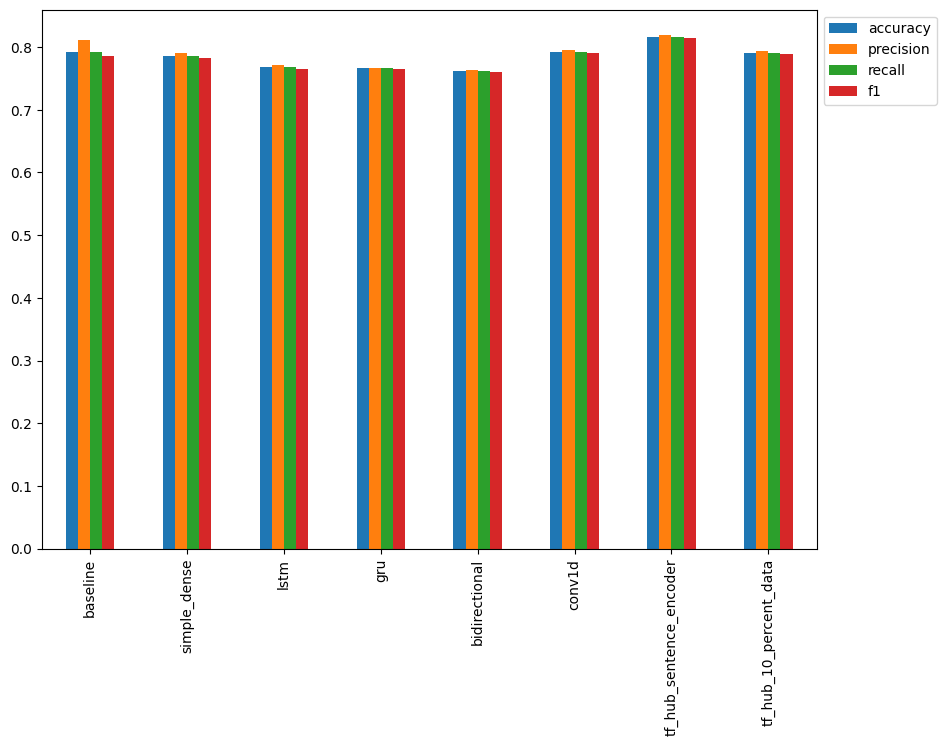

In [108]:
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

<Axes: >

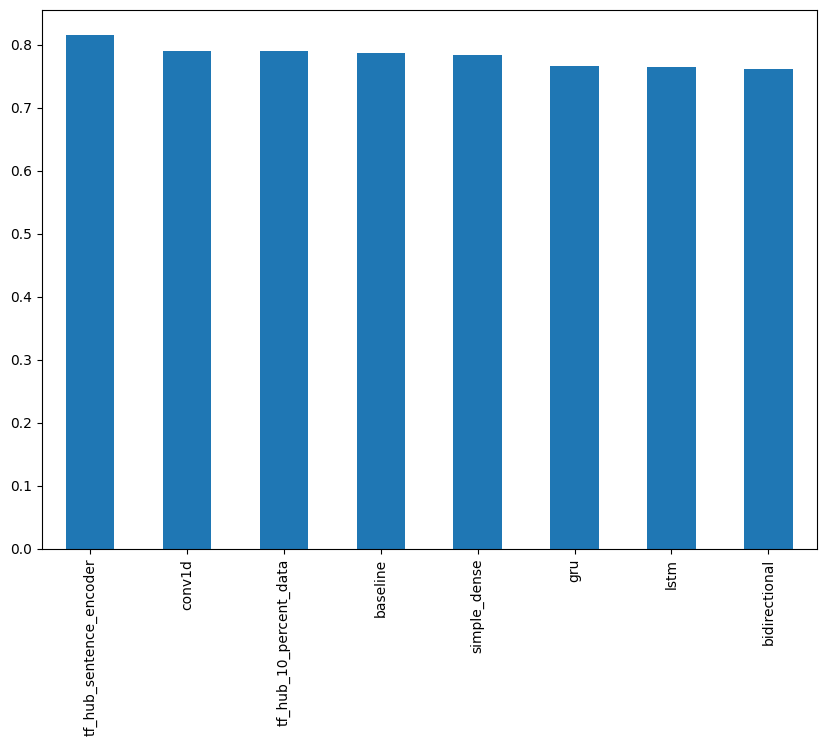

In [109]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

## Combining our models

In [112]:
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1.], dtype=float32)>

In [113]:
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.74015748031496,
 'precision': 0.7871689334287758,
 'recall': 0.7874015748031497,
 'f1': 0.7868411571882453}

In [114]:
all_model_results.loc["ensemble_results"] = ensemble_results

In [115]:
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"] / 100

In [116]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.786089,0.790328,0.786089,0.783297
lstm,0.767717,0.771980,0.767717,0.764369
gru,0.766404,0.766261,0.766404,0.765428
bidirectional,0.762467,0.763135,0.762467,0.760760
conv1d,0.792651,0.795808,0.792651,0.790406
tf_hub_sentence_encoder,0.816273,0.818755,0.816273,0.814709
tf_hub_10_percent_data,0.791339,0.793644,0.791339,0.789387
ensemble_results,0.787402,0.787169,0.787402,0.786841


## Saving and loading a trained model

* The `HDF5` format
* The `SavedModel` format

In [117]:
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [118]:
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [119]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4310 - accuracy: 0.8163


[0.43095436692237854, 0.8162729740142822]

In [120]:
model_6.save("model_6_SavedModel_format")

In [121]:
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [122]:
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 17ms/step - loss: 0.4310 - accuracy: 0.8163


[0.43095436692237854, 0.8162729740142822]

## Finding the most wrong examples

In [123]:
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.153563
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.731002
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.987386
3,@camilacabello97 Internally and externally scr...,1,0.0,0.184077
4,Radiation emergency #preparedness starts with ...,1,1.0,0.739396


In [124]:
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.914215
628,@noah_anyname That's where the concentration c...,0,1.0,0.852899
759,FedEx will no longer transport bioterror patho...,0,1.0,0.852625
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.842300
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.827989
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.804478
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.786612
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.778584
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.776240
144,The Sound of Arson,0,1.0,0.770561


In [125]:
for row in most_wrong[:10].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9142154455184937
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8528992533683777
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8526252508163452
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8423002362251282
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.827988862991333
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8044775724411011
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Pro

In [126]:
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.061076194047927856
Text:
'The way you move is like a full on rainstorm and I'm a house of cards'

----

Target: 1, Pred: 0, Prob: 0.060986101627349854
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.06083576753735542
Text:
Next May I'll be free...from school from obligations like family.... Best of all that damn curfew...

----

Target: 1, Pred: 0, Prob: 0.05095688998699188
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.044752396643161774
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.04270441457629204
Text:
Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amage

## Making predictions on the test dataset

In [128]:
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 38ms/step
Pred: 1, Prob: 0.8061410784721375
Text:
Bengal floods: CM Mamata Banerjee blames DVC BJP claims state failed to use relief funds: KOLKATA: Even as fl... http://t.co/WFwWRcmi9t

----

1/1 [==============================] - 0s 35ms/step
Pred: 0, Prob: 0.2684802711009979
Text:
that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time'

----

1/1 [==============================] - 0s 34ms/step
Pred: 0, Prob: 0.060166653245687485
Text:
#hot  Reddit's new content policy goes into effect many horrible subreddits banned or quarantined http://t.co/sqHDrl7uKG #prebreak #best

----

1/1 [==============================] - 0s 33ms/step
Pred: 1, Prob: 0.914886474609375
Text:
Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/nvSjHdGDGZ

----

1/1 [==============================] - 0s 59ms/step
Pred: 1, Prob: 0.9747588634490967
Text:
SkyNews: Migran

## The speed/score tradeoff

In [129]:
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.

  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [130]:
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 15ms/step


(0.7421534780000911, 0.0009739546955381774)

In [131]:
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.02983619900010126, 3.915511679803315e-05)

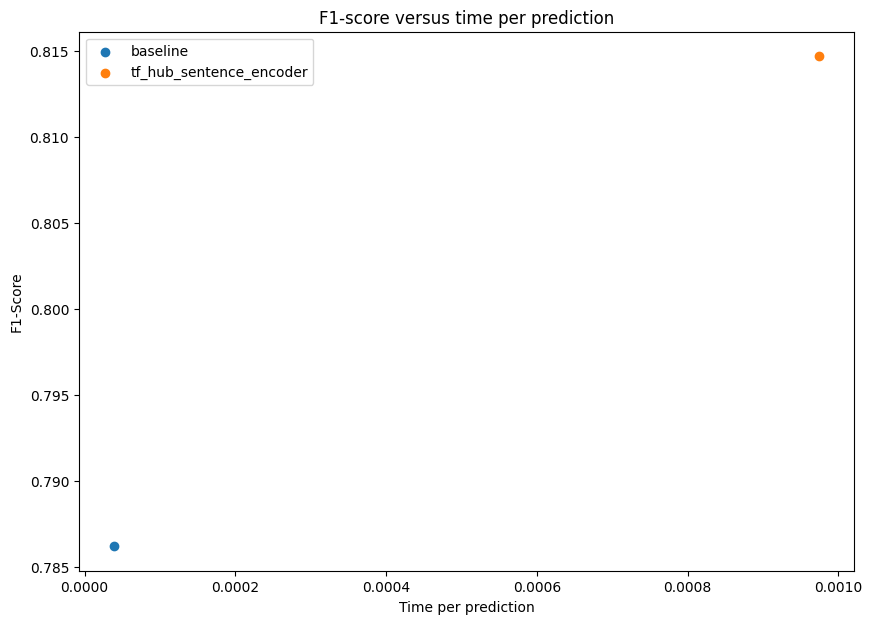

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");